# Physics 911 Term Project
### Mingyoung Jeng

Adapting aspects of Efficiently Updatable Neural Networks (NNUE) into quantum machine learning circuits.

### Efficiently Updatable Neural Networks (NNUE)

NNUEs are a type of neural network that has shown great advantage in engines designed to play shogi and chess, where they are used for positional evaluation. Compared to deep neural-networks like those used in DeepMind's Alpha- series of engines (e.g. AlphaZero in chess), they can be efficiently run on CPUs duea structure prioritizing efficiency.

First, the networks are shallow, but fully interconnected between nodes, resulting in a relatively small network. Second, they are sparse, meaning the expect the majority of inputs to be $0$, which enables efficient lazy updates between iterations.

Given the state of current quantum machines, the same motivations behind NNUEs could also hold for QPUs, especially the desire for shallower, less costly networks.

Sources: [Original Paper (JPN)](https://github.com/ynasu87/nnue/blob/master/docs/nnue.pdf), [Original Paper (Unofficial English translation)](https://github.com/asdfjkl/nnue/blob/main/nnue_en.pdf), [GitHub](https://github.com/glinscott/nnue-pytorch/blob/master/docs/nnue.md), [saumikn](https://saumikn.com/blog/a-brief-guide-to-stockfish-nnue/), [Chess.com](https://www.chess.com/blog/the_real_greco/evolution-of-a-chess-fish-what-is-nnue-anyway)

### Quantum Variational Algorithms

As a near-term classification algorithm, this algorithm formed the foundation upon which I implemented my NNUE-inspired circuit design. 

The general concept depends on two parameterized circuits which have a fixed structure whose gates (rotation gates, specifically) can be updated between executions to different values. The first circuit is a data encoding circuit, which parses the given inputs, and a variational circuit which returns a series of labels (measurements). These outputs are handled classicially by passing them into a cost function which is used by a gradient-descent optimizer to decide on the next iteration's set of parameters.

Source: [Qiskit](https://learn.qiskit.org/course/machine-learning/variational-classification)

### Project Objective

Determine a parameterized quantum ansatz that reflects the principal benefits of NNUEs.
* Efficient updating
* Sparse
* Shallow
* Fully interconnected

The closest analog in the quantum space that fulfills the same role of efficient iteration in NNUEs is circuit parameterization. While all quantum circuit need repeated measurement to achieve accurate results, circuit parameterization does allow the structure of a circuit to remain constant over all executions, with only the parameters needing to be updated.

I have chosen to interpret "sparseness" to mean that if any qubit is found to be in its ground state, it shouldn't have any effect on the final result.

Circuit depth is already a primary constraint in contemporary quantum algorithm design due to decoherence. Here, I specifically tried to target a $O(n)$ depth, where $n$ is the number of qubits.

Fully interconnected is already a natural concept in the quantum domain, due to superposition and entanglement. In practice, I looked for a circuit that ensured each qubit could have an effect on the final measurement.

### Adapting a typical variational circuit algorithm

As a control, we have the `qiskit` tutorial code for a variational classifier adapted to provide "evaluation" between $0.0-1.0$, as seen in classical NNUEs.

In this case, I chose an evaluation function that outputs the normalized entropy of the input statevector.

In [1]:
from qiskit import Aer
from qiskit.utils import algorithm_globals
from qiskit.providers.ibmq import least_busy
from qiskit_ibm_runtime import QiskitRuntimeService
algorithm_globals.random_seed = 69420

import numpy as np
np.random.seed(algorithm_globals.random_seed)

num_qubits = 7
num_training = 40
num_test = 20

# backend = Aer.get_backend('aer_simulator')

QiskitRuntimeService.save_account(channel='ibm_quantum', token='c9563bd517817e54e4685061f34bd94ef10e6a660dc8362761cb063f4512160ce3e16a7ae2b6a79382c445e8f8e3cdcd7a8d025ebc8067f347309665c7d258af')
QiskitRuntimeService.load_account()
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-research-2/uni-kansas-1/main',
)
backend =service.least_busy(simulator=False, operational=True, min_num_qubits=7)

Prepare function for the target evaluation

In [2]:
def eval(psi: np.ndarray) -> float:
    """
    This function gives the "correct" output for any input data
    Args:
        psi (list): Input statevector
    Returns:
        float: Value between 0.0 and 1.0
    """
    
    return -sum(psi * np.log2(psi + 1e-10)) / len(psi)

Prepare training and testing data

In [3]:
def random_data(qubits: int):
    """
    Generates random sparse datasets
    Args:
        qubits (int): number of qubits in statevector
    Returns:
        np.ndarray: statevector
    """
    psi = np.zeros(2**qubits)
    n = np.random.randint(1, 2**(qubits-1))
    psi[:n] = np.random.rand(n)
    np.random.shuffle(psi)
    psi = psi / np.linalg.norm(psi)
    return psi

train_data = [random_data(num_qubits) for _ in range(num_training)]
train_labels = [eval(x) for x in train_data]

test_data = [random_data(num_qubits) for _ in range(num_test)]
test_labels = [eval(x) for x in test_data]

The tutorial used a `ZZFeatureMap` for the data encoding circuit, but those could only go up to 3 qubits, so I used the general `initialize` function instead.

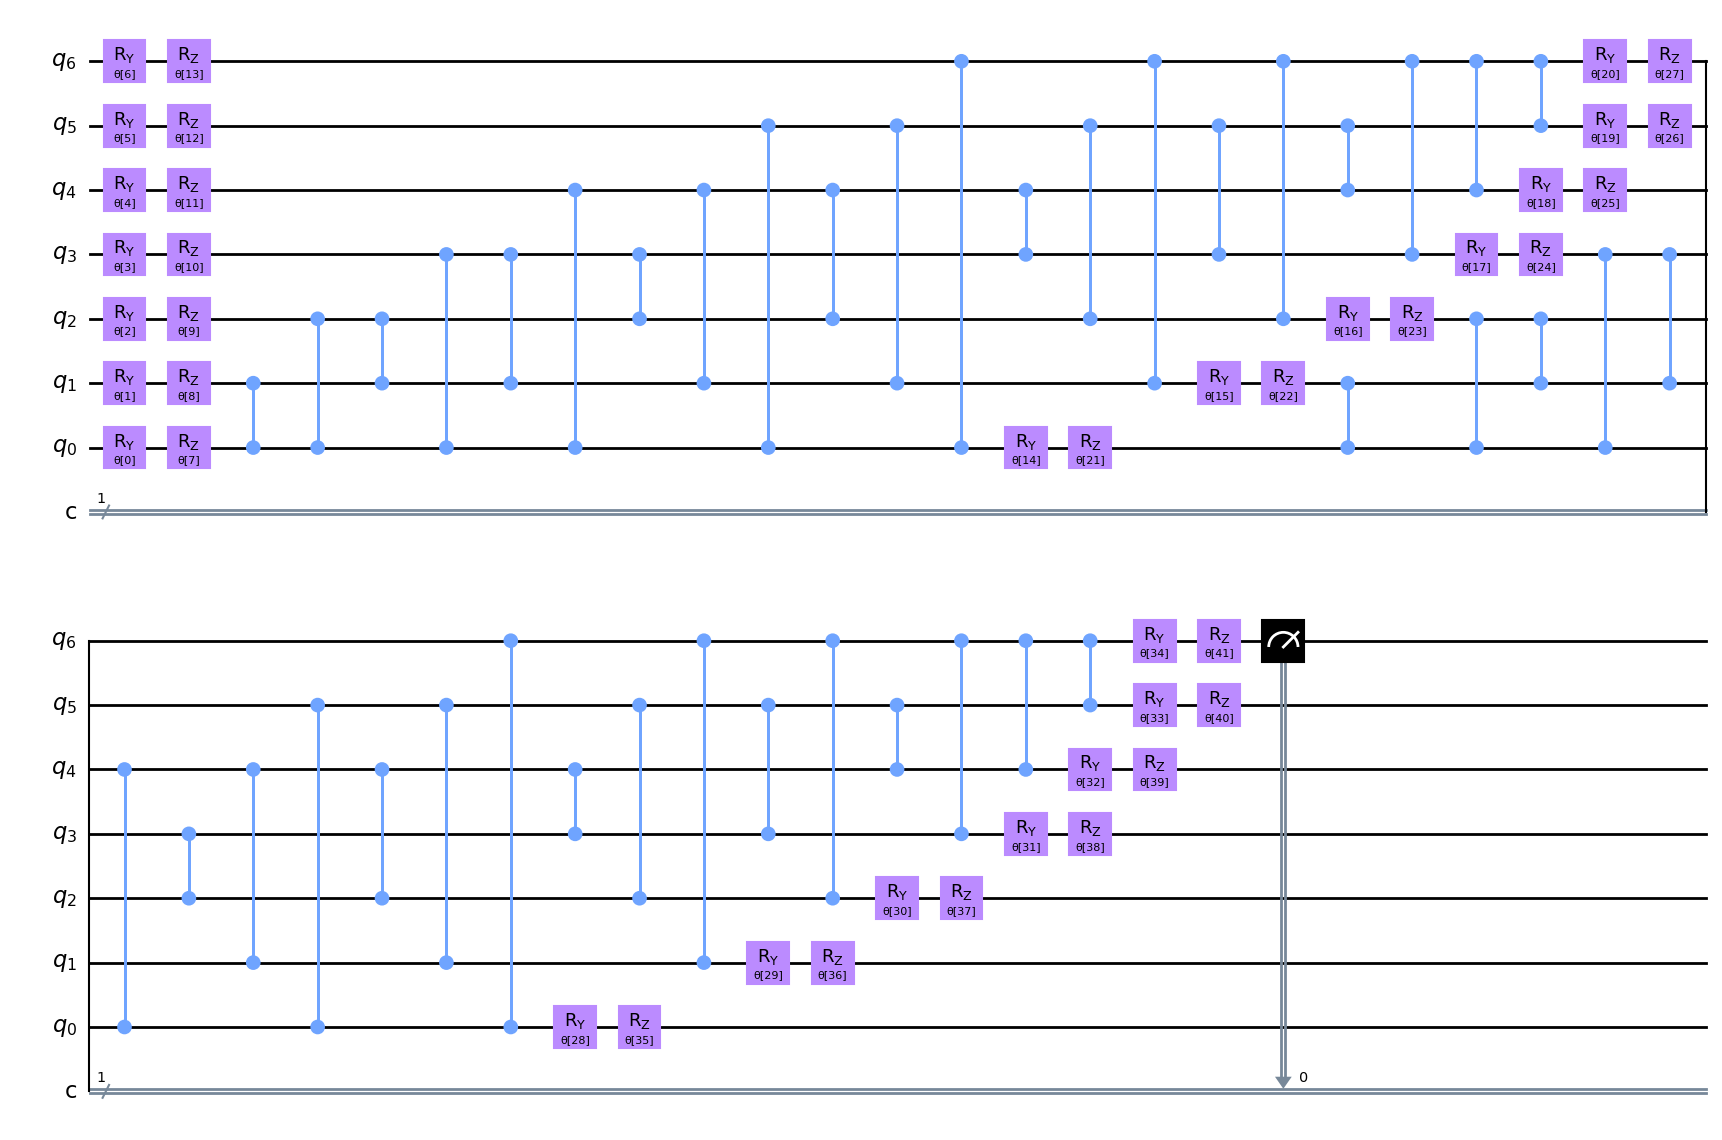

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal

QML = QuantumCircuit(num_qubits, 1)

var = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=2)
QML.compose(var, inplace=True)
        
QML.measure(num_qubits-1, 0)

num_variational = len(var.ordered_parameters)
        
QML.decompose().draw('mpl', reverse_bits=True)

In [5]:
def circuit_instance(data, variational):
    qc = QuantumCircuit(num_qubits)
    qc.initialize(data)
    qc.compose(QML.assign_parameters(variational), inplace=True)
    
    return qc

In [ ]:
from qiskit_ibm_runtime import Session, Sampler
sampler = None # Save for later

def label_probability(counts):
    if "0" not in counts.keys():
        return 0
    return counts["0"] / sum(counts.values())

def evaluation_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    results = sampler.run(circuits, backend).result()
    evals = [label_probability(results.get_counts(c), c) for c in circuits]
    
    return evals

def cost_function(data, labels, variational):
    classifications = evaluation_probability(data, variational)
    cost = sum([np.abs(classification - label) for classification, label in zip(classifications, labels)])
    return cost

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


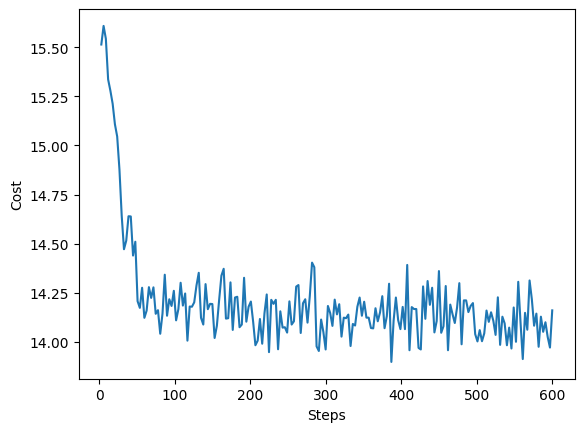

In [8]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA

with Session(service=service, backend=backend):
    sampler = Sampler()
    
    log = OptimizerLog()
    optimizer = SPSA(maxiter=200, callback=log.update)

    # Run the optimization
    initial_point = np.random.rand(num_variational)
    result = optimizer.minimize(objective_function, initial_point)

    opt_var = result.x
    opt_value = result.fun

    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(log.evaluations, log.costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.show()

Note how the cost minimization plateaus rapidly. We have hit a ceiling for this variational circuit. Since it was originally meant to be a classifier, perhaps this is not surprising.

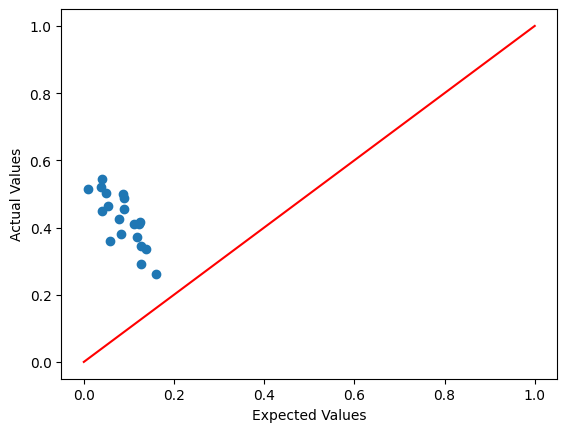

In [9]:
labels = evaluation_probability(test_data, opt_var)

fig = plt.figure()
plt.scatter(test_labels, labels)

x = np.linspace(0,1,100)
plt.plot(x, x, '-r', label='ideal')

plt.xlabel('Expected Values')
plt.ylabel('Actual Values')
plt.show()

Hard to see a good fit between the expected vs measured evaluations.

### Repeat the process with custom classification circuit

Below is the NNUE-inspired circuit design, motivated solely by the previously-discussed constraints. The circuit is very shallow, owing to the lack of phase gates, which doesn't affect the final probability measurements, and that only 1 qubit is measured. Evaluation only needs to return a value between 0 and 1, so only 1 qubit is required for that. Thus, all other qubits besides the target need only be used to control that target, adhering to the contraint that qubits in their ground state much serve as $I$ gates.

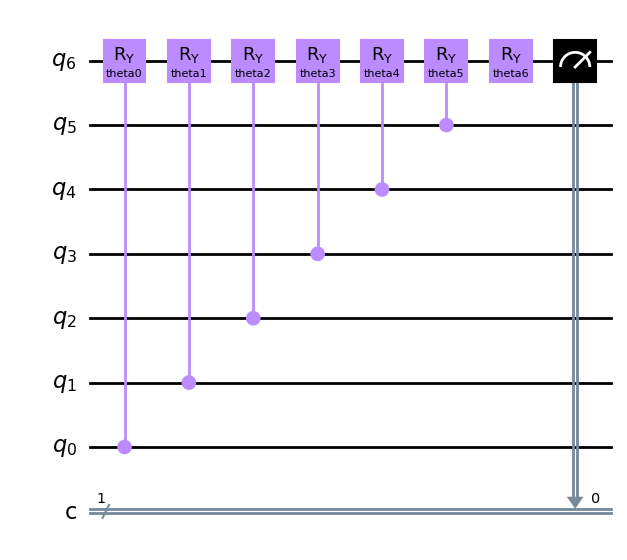

In [10]:
from qiskit.circuit import Parameter

QML = QuantumCircuit(num_qubits, 1)
target = num_qubits - 1

for i in range(num_qubits):
    theta = Parameter(f'theta{i}')
    
    if i == target:
        QML.ry(theta, target)
    else:
        QML.cry(theta, i, target)
        
QML.measure(target, 0)

num_variational = num_qubits
        
QML.draw('mpl', reverse_bits=True)

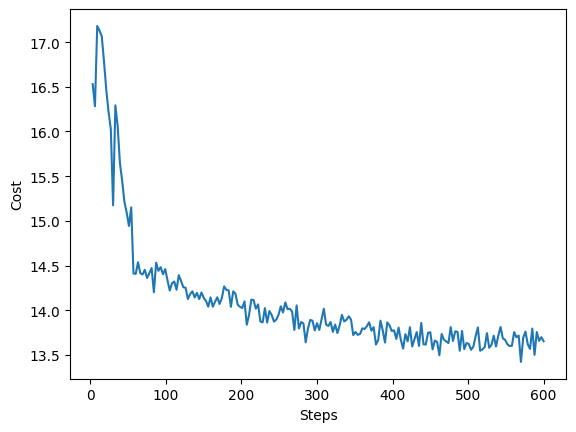

In [11]:
with Session(service=service, backend=backend):
    sampler = Sampler()
    
    log = OptimizerLog()
    optimizer = SPSA(maxiter=200, callback=log.update)

    # Run the optimization
    initial_point = np.random.rand(num_variational)
    result = optimizer.minimize(objective_function, initial_point)

    opt_var = result.x
    opt_value = result.fun

    fig = plt.figure()
    plt.plot(log.evaluations, log.costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.show()

Here, we see the shallower circuit marginally edge out the other circuit in terms of cost, but more importantly does not appear to be plateauing.

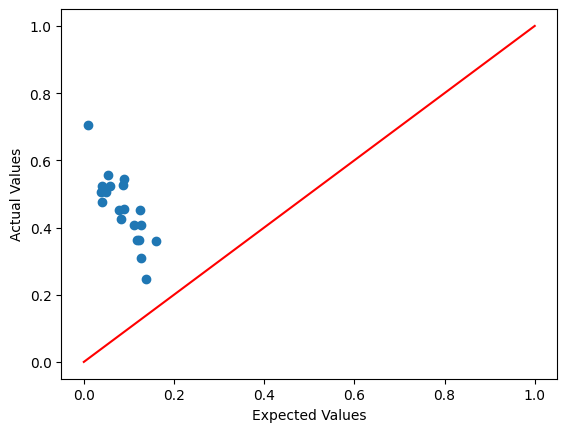

In [12]:
labels = evaluation_probability(test_data, opt_var)

fig = plt.figure()
plt.scatter(test_labels, labels)

x = np.linspace(0,1,100)
plt.plot(x, x, '-r', label='ideal')

plt.xlabel('Expected Values')
plt.ylabel('Actual Values')
plt.show()

However, the fit still isn't very strong, suggesting more iterations may be required.